In [2]:
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
from tensorflow import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.gpu import setup_gpu

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

# use this to change which GPU to use
#gpu = 0

# set the modified tf session as backend in keras
#setup_gpu(gpu)

In [2]:
!python ../keras-retinanet/keras_retinanet/bin/convert_model.py ../keras-retinanet/snapshots/saves/RetinaNet_Resnet50_Ilegal_Agri_Aug.h5 ../keras-retinanet/snapshots/saves/inference/RetinaNet_Resnet50_Ilegal_Agri_Aug.h5

2021-04-06 15:24:35.566120: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-04-06 15:24:36.391337: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-04-06 15:24:36.391913: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-04-06 15:24:36.430827: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-04-06 15:24:36.431471: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.91GiB deviceMemoryBandwidth: 451.17GiB/s
2021-04-06 15:24:36.431517: I tensorflow/stream_executor/cuda/cuda_gpu_

In [3]:
!python ../keras-retinanet/keras_retinanet/bin/evaluate.py  --gpu 0 --iou-threshold 0.5 csv ../../images/retina/illegal_Agri/csv/val_annotations.csv ../../images/retina/illegal_Agri_noAug/csv/classes.csv ../keras-retinanet/snapshots/saves/inference/RetinaNet_Resnet50_Ilegal_Agri_Aug.h5

2021-04-06 15:25:39.589604: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-04-06 15:25:40.451621: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-04-06 15:25:40.452243: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-04-06 15:25:40.489474: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-04-06 15:25:40.490084: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.91GiB deviceMemoryBandwidth: 451.17GiB/s
2021-04-06 15:25:40.490130: I tensorflow/stream_executor/cuda/cuda_gpu_

In [2]:
import tensorflow as tf
print(tf.test.gpu_device_name())

/device:GPU:0


In [54]:
import tensorflow as tf 

if tf.test.gpu_device_name(): 

    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

else:

   print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


In [51]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8282045122408322785
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1428674969
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6015046990234876640
physical_device_desc: "device: 0, name: GeForce GTX 960M, pci bus id: 0000:01:00.0, compute capability: 5.0"
]


In [3]:
# adjust this to point to your downloaded/trained model
# models can be downloaded here: https://github.com/fizyr/keras-retinanet/releases
#model_path = '../keras-retinanet/snapshots/resnet50_coco_best_v2.1.0.h5'
model_path = '../keras-retinanet/snapshots/saves/inference/RetinaNet_Resnet50_Ilegal_Agri_Aug.h5'

# load retinanet model
model = models.load_model(model_path, backbone_name='resnet50')

# if the model is not converted to an inference model, use the line below
# see: https://github.com/fizyr/keras-retinanet#converting-a-training-model-to-inference-model
#model = models.convert_model(model)

#print(model.summary())

# load label to names mapping for visualization purposes
#labels_to_names = {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microwave', 69: 'oven', 70: 'toaster', 71: 'sink', 72: 'refrigerator', 73: 'book', 74: 'clock', 75: 'vase', 76: 'scissors', 77: 'teddy bear', 78: 'hair drier', 79: 'toothbrush'}
labels_to_names = {0: 'ilegal'}

In [9]:
print(model.summary())

Model: "retinanet-bbox"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
padding_conv1 (ZeroPadding2D)   (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9408        padding_conv1[0][0]              
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
_____________________________________________________________________________________

processing time:  0.04944443702697754


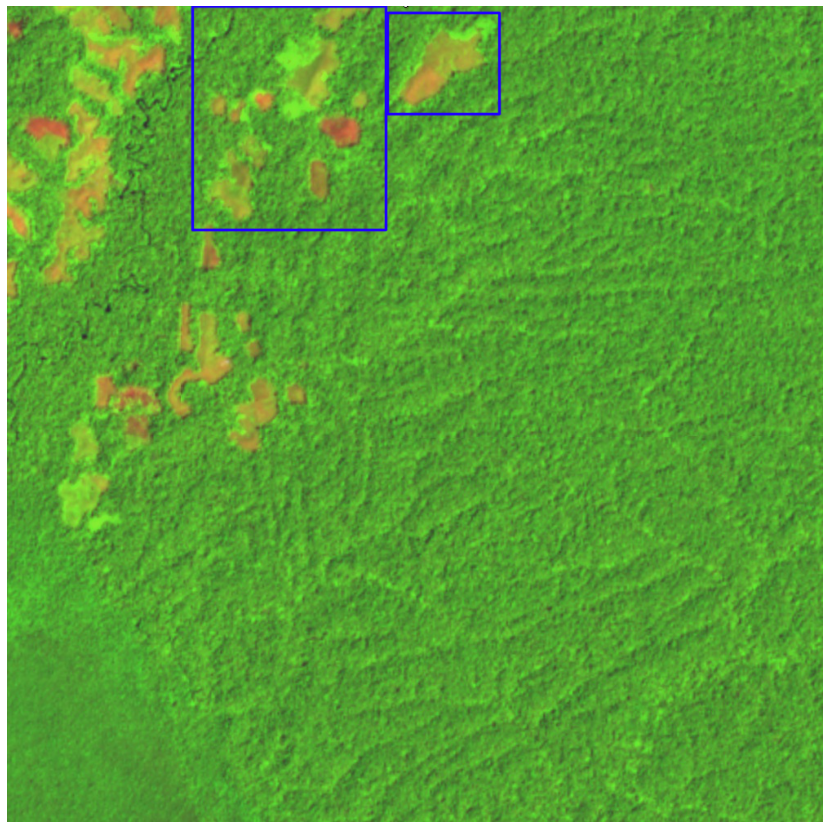

In [5]:
#image = read_image_bgr('../../images/retina/illegal_Agri_noAug/csv/-70_94__-3_51_2021-01-17.jpg')
#image = read_image_bgr('../../images/retina/illegal_Agri_noAug/csv/-53_74__0_52_2019-09-24.jpg')
image = read_image_bgr('../../images/retina/illegal_Agri_noAug/csv/-71_48__-3_56_2021-01-17.jpg')



# copy to draw on
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

# preprocess image for network
image = preprocess_image(image)
image, scale = resize_image(image)

# process image
start = time.time()
boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
print("processing time: ", time.time() - start)

# correct for image scale
boxes /= scale

# visualize detections
for box, score, label in zip(boxes[0], scores[0], labels[0]):
    # scores are sorted so we can break
    if score < 0.5:
        break
        
    color = label_color(label)
    
    b = box.astype(int)
    draw_box(draw, b, color=color)
    
    caption = "{} {:.3f}".format(labels_to_names[label], score)
    draw_caption(draw, b, caption)
    
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(draw)
plt.savefig('../-71_48__-3_56_2021-01-17-05.jpg')
plt.show()


In [12]:
!dir

 Le volume dans le lecteur C s'appelle OS
 Le num‚ro de s‚rie du volume est D413-8018

 R‚pertoire de C:\Users\natha\Documents\Keep\Cours\KTH\Master Thesis\Models\Impl

09/02/2021  14:15    <DIR>          .
09/02/2021  14:15    <DIR>          ..
05/02/2021  16:40    <DIR>          .ipynb_checkpoints
05/02/2021  19:25         2ÿ781ÿ705 coeur-ville4.jpg
05/02/2021  19:27           240ÿ664 personnes-agees.png
05/02/2021  16:36       152ÿ662ÿ144 resnet50_coco_best_v2.1.0.h5
09/02/2021  14:15         1ÿ166ÿ748 Untitled.ipynb
               4 fichier(s)      156ÿ851ÿ261 octets
               3 R‚p(s)   7ÿ221ÿ600ÿ256 octets libres
